# Experimental Results
In this notebook are presented the metrics to evaluate the results and assess the clustering quality.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

To use only if the data is stored on _Google Drive_

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Scores
Below are reported the definition of the used scores, then at the end of the notebook the obtained results.

### Minimum connection probability of a node to its center among all clusters

$ \min_{1 \leq i \leq k} \min_{v \in C_i} \Pr[c_i \sim v] $



In [3]:
#assumption: p[c ~ c] = 1.0 -> c ~ c connected -> path = {c}, sequence of 1 node
def compute_p_min(clustering, centers, p_list):
  
    p_min = 1.0
    for i in range(len(clustering)):
        center = centers[i] #center of cluster i
    
        #compare each node in cluster i with its center to find p_min
        for node in clustering[i]:

            dict_to_exp = p_list[int(node)]  #dict to explore
    
            try: prob_c_n = dict_to_exp[center]
            except KeyError: continue

            if prob_c_n < p_min:
                p_min = prob_c_n 

    return np.round(p_min, 4)  #global p_min 

### Average connection probability of a node to its center

$\frac{1}{n} \sum_{1 \leq i \leq k} \sum_{v \in C_i} \Pr[c_i \sim v], \;\:n = \sum_{1 \leq i \leq k}|C_i|$

Ideally $ n = \sum_{1 \leq i \leq k}|C_i| = |V|$, but from the clustering we could get some outlier nodes, i.e. nodes not assigned to any cluster.

In [4]:
def compute_p_avg(clustering, centers, p_list):

    p_sum = 0.0
    num_nodes = 0.0

    for i in range(len(clustering)):
        center = centers[i] #center of cluster i

        for node in clustering[i]:
            num_nodes += 1

            dict_to_exp = p_list[int(node)]  #dict to explore
            try: prob_c_n = dict_to_exp[center]
            except KeyError: continue

            p_sum += prob_c_n
      
    #p_avg[c_i ~ n], avg connection prob center c_i to node n in its cluster
    return np.round(p_sum/num_nodes, 4) 


### Evaluation of unclustered nodes 

Function to show the percentage of nodes that do not belong to any cluster

In [5]:
def outliers_percentage(clusters, unclustered_nodes):###

    cluster_sizes = [len(x) for x in clusters]
    num_nodes_clustered = sum(cluster_sizes)
    num_nodes_unclustered = len(unclustered_nodes)

    total_num_nodes = num_nodes_clustered + num_nodes_unclustered

    p = (num_nodes_unclustered/total_num_nodes) * 100

    #return percentage of unclustered nodes
    return np.round(p, 4) 

## Results

Read the output file given by the clustering, made of centers, clusters, and probability connection of the nodes.

The following is an helper function to load the results (_centers, unclusterd_nodes, clusters_) in the desired format.

In [6]:
#helper function to load the results (centers, unclusterd_nodes, clusters) in the desired format
def load_results(filename):

    centers = []
    unclustered_nodes = []
    clustering = []

    is_first_line = True
    is_second_line = False
    

    with open(filename, "r") as dataset:

        for line in dataset:
            tmp_cluster = []

            if is_first_line:
                is_first_line = False
                is_second_line = True
                tokens = line.split()
                for t in tokens:
                    centers.append(int(t))

            elif is_second_line:
                is_second_line = False
                tokens = line.split()
                for t in tokens:
                    unclustered_nodes.append(int(t))

            elif is_second_line == False and is_second_line == False:
                tokens = line.split()
                for t in tokens:
                    tmp_cluster.append(int(t))
                clustering.append(tmp_cluster)


    return centers, clustering, unclustered_nodes

Helper function to load the probabilities in the desired format.

In [7]:
def load_probabilities(filename):
    prob_dict = {}
    with open(filename, "r") as dataset:
        for line in dataset:
            tokens = line.split()
            key = tokens[0]   


            tmp_dict = {}
            for i in range(1, len(tokens)):
                if (i % 2) == 0:   
                    continue
                t = int(tokens[i]) 
                tmp_dict[t] = float(tokens[i+1]) 

            prob_dict[int(key)] = tmp_dict

    return prob_dict

#format: dict of dicts = {2: {486:0.29, 177:0.0026}, 7: {486:0.79}}

The following is an helper function to draw the results.

In [13]:
def print_plot_new():

    labels = ['10', '15', '20']
    pmin = [20, 34, 30]
    pavg = [25, 32, 34]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, pmin, width, label='p_MIN',
                  color = "white", edgecolor='black', hatch = "xx")
    rects2 = ax.bar(x + width/2, pavg, width, label='p_AVG',color = "lightgray", edgecolor='black' )
    plt.ylim(top=1.6*35)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('prob', fontsize = 14)
    ax.set_title('Krogan', fontsize = 14)
    ax.set_xticks(x, labels)
    ax.legend()

    ax.bar_label(rects1, padding=5, fontsize = 13, rotation = 90)
    ax.bar_label(rects2, padding=5, fontsize = 13, rotation = 90)

    fig.tight_layout()

    plt.show()

### Start of the results computations

Loading:

In [58]:
path = str(Path(os.path.abspath(os.getcwd())))
inputdir = path + "/data/results/"

inputfile_r = inputdir + "KM_collins_100nodes_k5_t10.txt"
inputfile_p = inputdir + "RP_collins_100nodes.txt"

centers, clusters, unclustered_nodes = load_results(inputfile_r)
p_dict = load_probabilities(inputfile_p)

#KM_collins_5_new_final_a_7.txt
#print(unclustered_nodes)
#KM_collins_100nodes_k5_t10.txt
#RP_collins_100nodes.txt


Computation of the scores:

In [59]:
p_min = compute_p_min(clusters, centers, p_dict)
p_avg = compute_p_avg(clusters, centers, p_dict)

percentage_unc_nodes = outliers_percentage(clusters, unclustered_nodes)

print("Min prob connection: ", p_min)
print("Avg prob connection: ", p_avg)
print("Percentage of unclustered nodes \(%\) : ", percentage_unc_nodes)


Min prob connection:  0.9907
Avg prob connection:  0.9999
Percentage of unclustered nodes \(%\) :  29.0


In [16]:

path = str(Path(os.path.abspath(os.getcwd())))
inputdir = path + "/data/results/"

inputfile_r = inputdir + "KM_reduced_collins_k20_t10_stopped.txt"
inputfile_p = inputdir + "RP_reduced_collins.txt"

centers, clusters, unclustered_nodes = load_results(inputfile_r)
p_dict = load_probabilities(inputfile_p)

#print(centers)
#print(unclustered_nodes)
#print(clusters)
#print(p_dict)


In [17]:
p_min = compute_p_min(clusters, centers, p_dict)
p_avg = compute_p_avg(clusters, centers, p_dict)

percentage_unc_nodes = outliers_percentage(clusters, unclustered_nodes)

print("Min prob connection: ", p_min)
print("Avg prob connection: ", p_avg)
print("Percentage of unclustered nodes \(%\) : ", percentage_unc_nodes)


Min prob connection:  0.393
Avg prob connection:  0.8938
Percentage of unclustered nodes \(%\) :  7.9681


In [54]:
path = str(Path(os.path.abspath(os.getcwd())))
inputdir = path + "/data/results/"

inputfile_r = inputdir + "KM_collins_10_new_final.txt"
inputfile_p = inputdir + "RP_collins_10_new_final.txt"

centers, clusters, unclustered_nodes = load_results(inputfile_r)
p_dict = load_probabilities(inputfile_p)

#print(centers)
#print(unclustered_nodes)
#print(clusters)
#print(p_dict)


In [55]:
p_min = compute_p_min(clusters, centers, p_dict)
p_avg = compute_p_avg(clusters, centers, p_dict)

percentage_unc_nodes = outliers_percentage(clusters, unclustered_nodes)

print("Min prob connection: ", p_min)
print("Avg prob connection: ", p_avg)
print("Percentage of unclustered nodes \(%\) : ", percentage_unc_nodes)



Min prob connection:  1.0
Avg prob connection:  1.0
Percentage of unclustered nodes \(%\) :  29.703


Drawing of the scores to visualize the results.

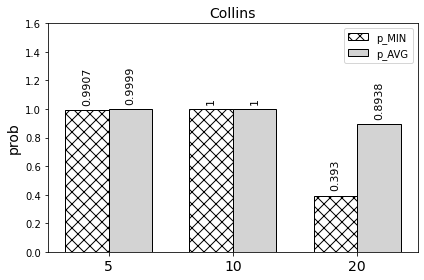

In [50]:
def c_print_plot_new():

    labels = ['5', '10', '20']
    pmin = [0.9907, 1,0.393]
    pavg = [0.9999, 1,0.8938]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, pmin, width, label='p_MIN',
                  color = "white", edgecolor='black', hatch = "xx")
    rects2 = ax.bar(x + width/2, pavg, width, label='p_AVG',color = "lightgray", edgecolor='black' )
    plt.ylim(top=1.6*1)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('prob', fontsize = 14)
    ax.set_title('Collins', fontsize = 14)
    ax.set_xticks(x, labels, fontsize = 14)
    ax.legend()

    ax.bar_label(rects1, padding=5, fontsize = 11, rotation = 90)
    ax.bar_label(rects2, padding=5, fontsize = 11, rotation = 90)

    fig.tight_layout()

    plt.show()

c_print_plot_new()


In [22]:
# krogan 1


path = str(Path(os.path.abspath(os.getcwd())))
inputdir = path + "/data/results/"

inputfile_r = inputdir + "KM_krogan_10_nsettimi_new_final.txt"
inputfile_p = inputdir + "RP_krogan_10_nsettimi_new_final.txt"

centers, clusters, unclustered_nodes = load_results(inputfile_r)
p_dict = load_probabilities(inputfile_p)

#print(centers)
#print(unclustered_nodes)
#print(clusters)
#print(p_dict)


In [23]:
p_min = compute_p_min(clusters, centers, p_dict)
p_avg = compute_p_avg(clusters, centers, p_dict)

percentage_unc_nodes = outliers_percentage(clusters, unclustered_nodes)

print("Min prob connection: ", p_min)
print("Avg prob connection: ", p_avg)
print("Percentage of unclustered nodes \(%\) : ", percentage_unc_nodes)

Min prob connection:  0.0906
Avg prob connection:  0.7927
Percentage of unclustered nodes \(%\) :  4.3716


In [24]:
#krogan 2

path = str(Path(os.path.abspath(os.getcwd())))
inputdir = path + "/data/results/"

inputfile_r = inputdir + "KM_krogan_15_nsettimi_new_final.txt"
inputfile_p = inputdir + "RP_krogan_15_nsettimi_new_final.txt"

centers, clusters, unclustered_nodes = load_results(inputfile_r)
p_dict = load_probabilities(inputfile_p)

#print(centers)
#print(unclustered_nodes)
#print(clusters)
#print(p_dict)


In [25]:
p_min = compute_p_min(clusters, centers, p_dict)
p_avg = compute_p_avg(clusters, centers, p_dict)

percentage_unc_nodes = outliers_percentage(clusters, unclustered_nodes)

print("Min prob connection: ", p_min)
print("Avg prob connection: ", p_avg)
print("Percentage of unclustered nodes \(%\) : ", percentage_unc_nodes)


Min prob connection:  0.0992
Avg prob connection:  0.7959
Percentage of unclustered nodes \(%\) :  4.3716


In [26]:
#krogan 3


path = str(Path(os.path.abspath(os.getcwd())))
inputdir = path + "/data/results/"

inputfile_r = inputdir + "KM_krogan_20_nsettimi_new_final.txt"
inputfile_p = inputdir + "RP_krogan_20_nsettimi_new_final.txt"

centers, clusters, unclustered_nodes = load_results(inputfile_r)
p_dict = load_probabilities(inputfile_p)

#print(centers)
#print(unclustered_nodes)
#print(clusters)
#print(p_dict)


In [27]:
p_min = compute_p_min(clusters, centers, p_dict)
p_avg = compute_p_avg(clusters, centers, p_dict)

percentage_unc_nodes = outliers_percentage(clusters, unclustered_nodes)

print("Min prob connection: ", p_min)
print("Avg prob connection: ", p_avg)
print("Percentage of unclustered nodes \(%\) : ", percentage_unc_nodes)

Min prob connection:  0.0789
Avg prob connection:  0.7888
Percentage of unclustered nodes \(%\) :  4.3716


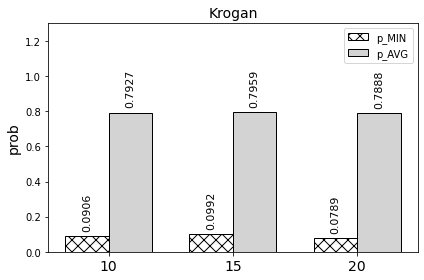

In [51]:
def c_print_plot_new():

    labels = ['10', '15', '20']
    pmin = [0.0906, 0.0992,0.0789]
    pavg = [0.7927, 0.7959,0.7888]

    x = np.arange(len(labels))# the label locations

    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, pmin, width, label='p_MIN',
                  color = "white", edgecolor='black', hatch = "xx")
    rects2 = ax.bar(x + width/2, pavg, width, label='p_AVG',color = "lightgray", edgecolor='black' )
    plt.ylim(top=1.3*1)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('prob', fontsize = 14)
    ax.set_title('Krogan', fontsize = 14)
    ax.set_xticks(x, labels, fontsize = 14)
    ax.legend()

    ax.bar_label(rects1, padding=5, fontsize = 11, rotation = 90)
    ax.bar_label(rects2, padding=5, fontsize = 11, rotation = 90)

    fig.tight_layout()

    plt.show()

c_print_plot_new()
